In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [2]:
import sys
sys.path.append(r'c:\Users\ice\projects\iris')

from PIL import Image
from tqdm.notebook import tqdm
import plotly.graph_objects as go
from IPython.display import display, HTML
import base64
from io import BytesIO

from iris.config.data_pipeline_config_manager import DataPipelineConfigManager
from iris.config.embedding_pipeline_config_manager import EmbeddingPipelineConfigManager
from iris.data_pipeline.mongodb_manager import MongoDBManager
from iris.data_pipeline.qdrant_manager import QdrantManager
from iris.embedding_pipeline.embedding_handler import EmbeddingHandler

In [3]:
# Initialize configuration managers
data_config = DataPipelineConfigManager()
embedding_config = EmbeddingPipelineConfigManager()

shop_config = data_config.shop_config
mongodb_config = data_config.mongodb_config
qdrant_config = data_config.qdrant_config

# Create managers
mongodb_manager = MongoDBManager(mongodb_config)
qdrant_manager = QdrantManager(qdrant_config)

# Initialize the EmbeddingHandler
embedding_handler = EmbeddingHandler(embedding_config.clip_config)

In [5]:
# Convert cursor to list since it can only be iterated once
image_dataset = list(mongodb_manager.get_collection(
    mongodb_manager.mongodb_config.image_metadata_collection
).find())

# Create Qdrant collection for embeddings
collection_name = qdrant_config.image_collection
vector_size = 512  # CLIP embedding size

with qdrant_manager as qm:
    qm.create_collection(collection_name, vector_size, recreate=True)
    
    # Add a progress bar with total count
    for i, image_data in enumerate(tqdm(image_dataset, desc="Processing images", total=len(image_dataset))):
        # Process main image
        with Image.open(image_data['local_path']).convert("RGBA") as img:
            width, height = img.size  # Get image dimensions

            # Get embedding and add to Qdrant
            embedding = embedding_handler.get_augmented_embedding(img)
            qm.upsert_points(
                collection_name,
                vectors=[embedding],
                payloads=[{"type": "full_image", "image_hash": image_data['image_hash'], "local_path": image_data['local_path']}],
                ids=[i]
            )
            
            # Process localizations if they exist
            if 'localizations' in image_data:
                for j, localization in enumerate(image_data['localizations']):
                    # Get bounding box from original image
                    bbox = localization['bbox']  # [x, y, width, height]
                    bbox_img = img.crop((
                        bbox[0] * width, 
                        bbox[1] * height, 
                        (bbox[0] + bbox[2]) * width, 
                        (bbox[1] + bbox[3]) * height
                    ))
                    
                    # Get embedding and add to Qdrant
                    localization_embedding = embedding_handler.get_augmented_embedding(bbox_img)
                    qm.upsert_points(
                        collection_name,
                        vectors=[localization_embedding],
                        payloads=[{
                            "type": "localization",
                            "localization_hash": localization['localization_hash'],
                            "parent_image_hash": image_data['image_hash'],
                            "local_path": image_data['local_path'],
                            "bbox": bbox
                        }],
                        ids=[i * 1000 + j + 1]  # Ensure unique IDs
                    )

print("Complete! Database created in Qdrant")

Processing images:   0%|          | 0/366 [00:00<?, ?it/s]

Complete! Database created in Qdrant


In [8]:
# Get example image embedding
query_hash = 'f1543c1b359945d75e695710d0006c9b'
query_image_data = next(img for img in image_dataset if img['image_hash'] == query_hash)

with Image.open(query_image_data['local_path']).convert("RGBA") as img:
    query_embedding = embedding_handler.get_augmented_embedding(img)

# Search for nearest neighbors
with qdrant_manager as qm:
    results = qm.search_points(qdrant_config.image_collection, query_embedding, limit=50)
print("Found", len(results), "similar images")

Found 50 similar images


In [9]:
def get_image_html(result, size=(100, 140)):
    """Create HTML img tag for a search result"""
    with Image.open(result.payload['local_path']) as img:
        if result.payload['type'] == 'localization':
            bbox = result.payload['bbox']
            width, height = img.size
            img = img.crop((
                bbox[0] * width,
                bbox[1] * height,
                (bbox[0] + bbox[2]) * width,
                (bbox[1] + bbox[3]) * height
            ))
        
        img.thumbnail(size)
        buffered = BytesIO()
        img.save(buffered, format='JPEG', quality=70)
        img_b64 = base64.b64encode(buffered.getvalue()).decode()
        return f'<img src="data:image/jpeg;base64,{img_b64}" style="max-width:none">'


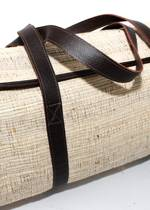
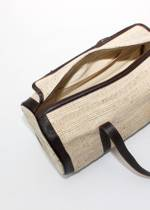
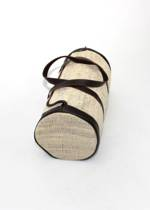
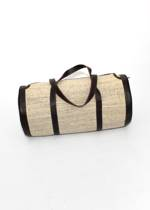
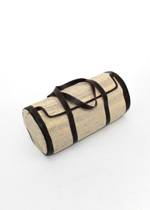
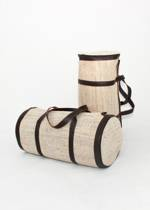
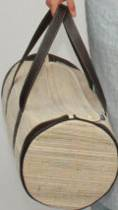
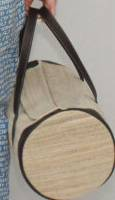
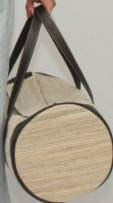
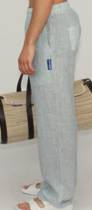
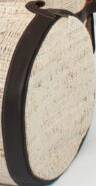
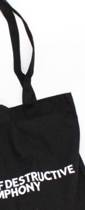
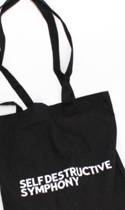
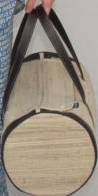
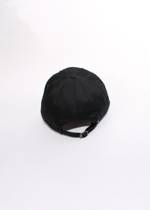
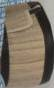
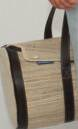
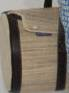
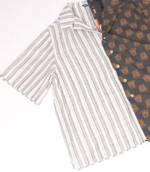
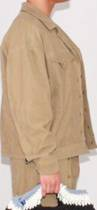
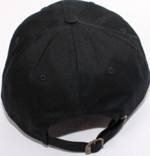
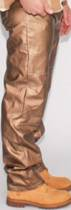
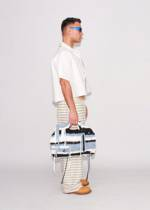
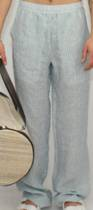
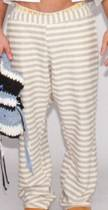
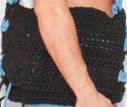
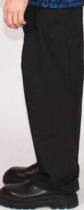
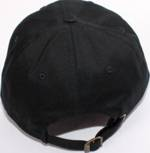
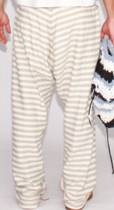
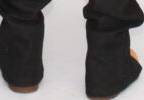
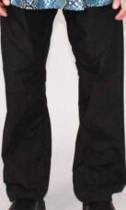
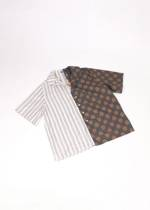
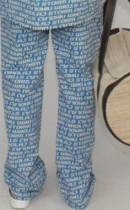
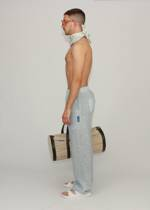
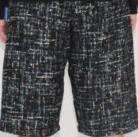
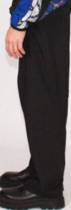
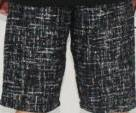
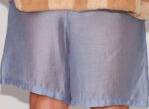
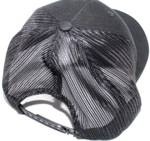
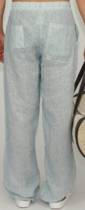
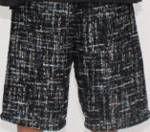
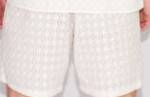
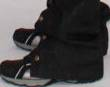
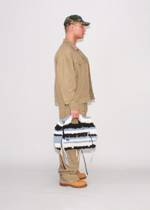
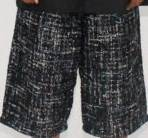
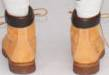
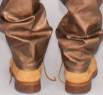
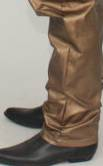
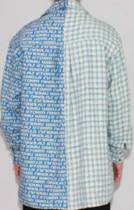
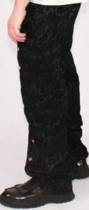

In [10]:
# Extract data for plot
indices = list(range(len(results)))
distances = [1 - result.score for result in results]  # Convert cosine similarity to distance

# Create scatter plot with simpler hover text
fig = go.Figure(data=go.Scatter(
    x=indices,
    y=distances,
    mode='lines+markers',
    marker=dict(size=8),
    text=[f'Index: {i}<br>ID: {result.id}<br>Distance: {1-result.score:.4f}<br>Type: {result.payload["type"]}' 
          for i, result in enumerate(results)],
    hovertemplate='%{text}<extra></extra>'
))

fig.update_layout(
    title='Image Similarity Plot',
    xaxis_title='Index',
    yaxis_title='Distance',
    width=800,
    height=400,
    showlegend=False
)

# Display plot
fig.show()

# Create grid of thumbnails below the plot
html = ['<div style="display: flex; flex-wrap: wrap; gap: 10px;">']

for i, result in enumerate(results):
    img_html = get_image_html(result, size=(150, 210))
    item_html = f"""
    <div style='text-align: center; border: 1px solid #ddd; padding: 5px;'>
        {img_html}
        <br>
        <small>Index: {i}</small><br>
        <small>Distance: {1-result.score:.4f}</small><br>
        <small>ID: {result.id}</small><br>
        <small>Type: {result.payload['type']}</small>
    </div>
    """
    html.append(item_html)

html.append('</div>')
display(HTML(''.join(html)))